In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_management import load_tsv
from data_utils import string_encoding_to_datetime, select_by_dict, print_unique_values
from datetime import datetime
plt.rcParams['figure.figsize'] = 10, 8

# Time series Analysis of Nights spent in tourist accomodation by country of destination

loading the data

In [7]:
nights_spent = load_tsv("tour_occ_nim.tsv", decode=True)
print_unique_values(nights_spent)
sub = select_by_dict(nights_spent, {
    "c_resid": "Foreign country",
    "unit": "Number",
    "nace_r2": "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks"
})

c_resid
	Foreign country
	Reporting country
	Total
unit
	Number
	Percentage change compared to same period in previous year
nace_r2
	Hotels and similar accommodation
	Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Holiday and other short-stay accommodation
	Holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Camping grounds, recreational vehicle parks and trailer parks
geo
	Albania
	Austria
	Belgium
	Bulgaria
	Switzerland
	Cyprus
	Czechia
	Germany (until 1990 former territory of the FRG)
	Denmark
	Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
	Estonia
	Greece
	Spain
	European Union - 27 countries (2007-2013)
	European Union - 28 countries
	Finland
	France
	Croatia
	Hungary
	Ireland
	Iceland
	Italy
	Liechtenstein
	Lithuania
	Luxembourg
	Latvia
	Montenegro
	North Macedonia
	Malta
	Netherlands
	Norway
	Poland
	Portugal
	

In [8]:
def get_country_time_series(name):
    data = select_by_dict(sub, {
        "geo": name
    })
    data = data.dropna()
    data["time"] = data["time"].apply(string_encoding_to_datetime)
    data = data.set_index("time").sort_index()
    return data

### We will look at the top 3 countries based on nights spent by tourists in them. 
namely: 
* Spain
* France
* Italy

(UK was excluded because of missing data)

# Spain

In [9]:
# get the data
spain = get_country_time_series('Spain')

The Autocorrelation plot below shows that the data is clearly seasonal. (which is also confirmed by the original plot)
The main trend in the data causes the amplitude of autocorrelation to drop by increasing the lag. The autocorrelation plot shows 3 distinct distinct regions that correspond to changing trends in the original data

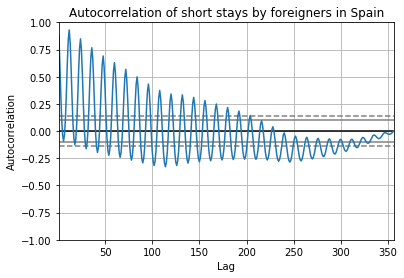

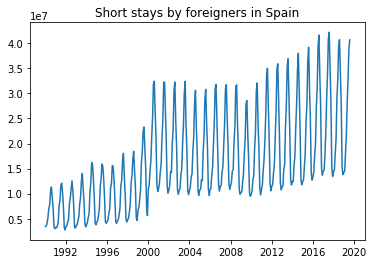

In [10]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(spain)
plt.title("Autocorrelation of short stays by foreigners in Spain")
plt.show()
plt.title("Short stays by foreigners in Spain")
plt.plot(spain)
plt.show()

Here a simple moving avrage aproach is used to decompose the data into :
* main trens
* seasonal trends
* noise

added together they make up the main time series.

We can see there is an increasing main trend for tourism in spain.
The seasonality is also clearly visible.

<Figure size 36000x36000 with 0 Axes>

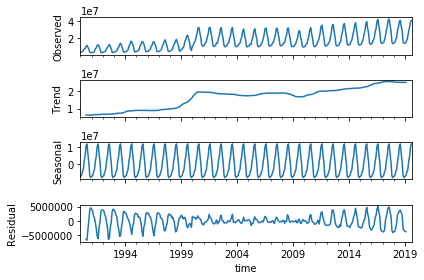

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(spain, model='additive')
plt.figure(figsize=(500,500))
result.plot()
plt.show()


### The SARIMA model to predict the future

now we will use the seasonal ARIMA model to predict how many nights tourists will spend in spain.

Here we fit the arima parameters the best seems to be (2,1,2)

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    



In [ ]:
# parameter to try
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(spain.value, p_values, d_values, q_values)

below we will train the arima on the train set to do feed-forward validation on the test to calculate the RMSE of the model. 
we also plot the results.
At the end we train on the whole data and predict 2 years ahead. the condidence interval of 95% is ploted in gray.

In [13]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from dateutil.relativedelta import relativedelta
warnings.filterwarnings("ignore")

def my_SARIMA(data, opt_params, plot_from=0):
    #plot_from only used for the last plot
    
    # sort the data by time
    data = data.sort_index()
    
    #############################
    # walk-forward validation
    print('walk-forward validation(takes time!):')
    
    # split into train and test sets
    X = data.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    
    # the past data and the feedforward pedictions 
    history = [x for x in train]
    predictions = list()
    
    # walk-forward validation
    for t in range(len(test)):
        # fit model
        model = sm.tsa.statespace.SARIMAX(history,
                                    order = opt_params,
                                    seasonal_order = (opt_params[0], opt_params[1], opt_params[2], 12),
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)

        model_fit = model.fit()
        # one step forecast
        yhat = model_fit.forecast(steps=1)
        # store forecast and observation
        predictions.append(yhat)
        history.append(test[t])
    
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    # plot forecasts against actual outcomes
    plt.figure(figsize=(10,8))
    plt.plot(test, label='actual')
    plt.plot(predictions, label='Forecast', alpha=0.6, color='red')
    plt.title('Walk-forward evaluation')
    plt.legend()
    plt.show()   
    
    ##############################
    # finally forcast the future
    # first train on the whole data
    mod = sm.tsa.statespace.SARIMAX(data,
                                    order = opt_params,
                                    seasonal_order = (opt_params[0], opt_params[1], opt_params[2], 12),
                                    enforce_stationarity = False,
                                    enforce_invertibility = False)
    results = mod.fit()
    
    # get 2 years ahead forcast
    pred_uc = results.get_forecast(steps=24)
    # confidence interval for forcast
    pred_ci = pred_uc.conf_int()
    
    # plot the main data
    ax = data[plot_from:].plot(label = 'Actual', figsize=(15,8))
    
    # if preds is not datetime fix it (and ci)
    preds = pred_uc.predicted_mean 
    if isinstance(preds.index, pd.RangeIndex):
        # produce index
        base = data.tail(1).index.date[0]
        new_index = list()
        for i in range(0,len(preds)):
            index = base + relativedelta(months=+(i+1))
            new_index.append(index)
        # update indicies
        preds.index = pd.DatetimeIndex(new_index)
        pred_ci.index = pd.DatetimeIndex(new_index)
    
    # plot presictions and CI
    preds.plot(ax=ax, label='Forecasted')
    ax.fill_between(pred_ci.index,
                       pred_ci.iloc[:,0],
                       pred_ci.iloc[:,1],
                       color='k', alpha=0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Nights spent')
    plt.title('Future forecast')
    plt.legend()
    plt.show()

walk-forward validation(takes time!):
Test RMSE: 772309.313


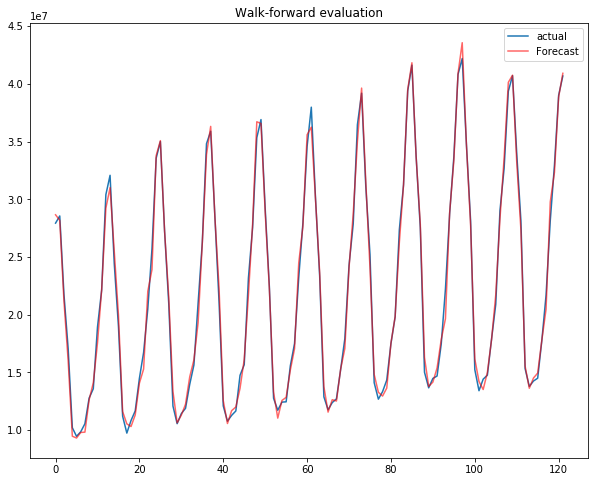

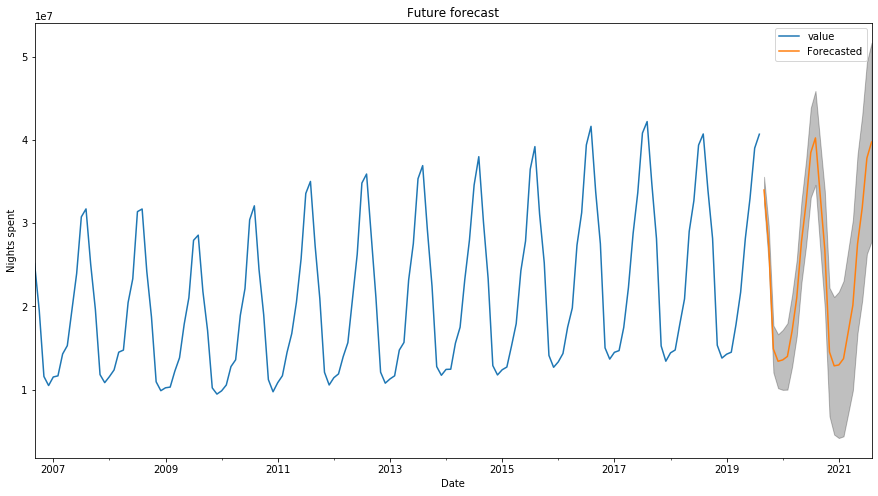

In [203]:
my_SARIMA(spain, (2,1,2), 200)

# France

In [149]:
# get the data
france = get_country_time_series('France')

France has some missing data in the past thus the weird line segments.
Again the autocorrelation confirms a seasonal pattern in our data

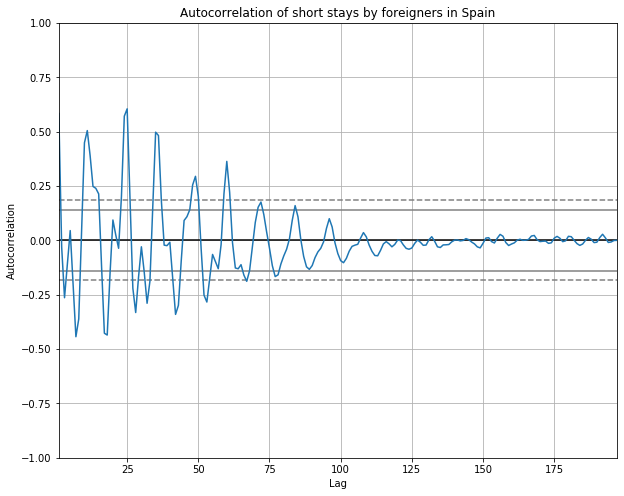

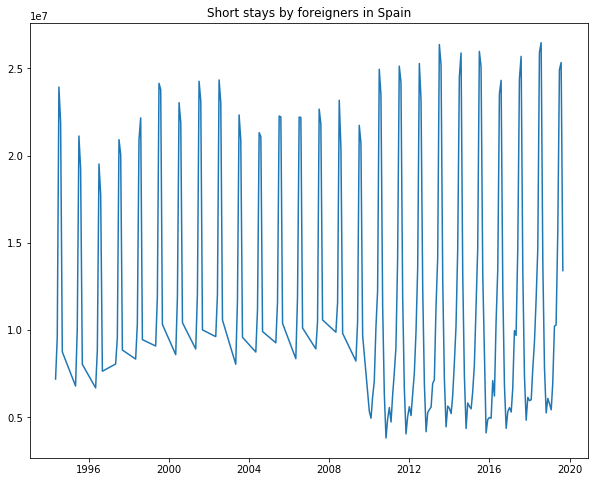

In [151]:
autocorrelation_plot(france)
plt.title("Autocorrelation of short stays by foreigners in France")
plt.show()
plt.title("Short stays by foreigners in France")
plt.plot(france)
plt.show()

Decomposing seasonality.
Since the amplitude of the signal is changing in each section we will use a multiplicative model.

<Figure size 36000x36000 with 0 Axes>

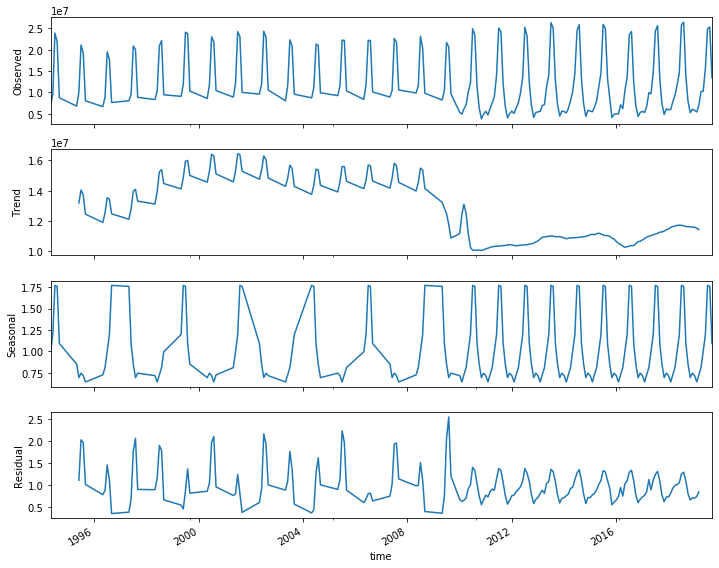

In [177]:
result = seasonal_decompose(france, model='multiplicative', freq=12)
plt.figure(figsize=(500,500))
result.plot()
plt.show()

The decomposition fails due to the missing data in the past that mess up the seasonality pattern. 
But if we look at the data after 2010 we can see that the seasonal pattern is decomposed well.
We can see that the main trend of France has a lot of fluctuation. Droping in 2010 and then rising, falling and rising again.

In [178]:
france_after_2010 = france[80:]

<Figure size 36000x36000 with 0 Axes>

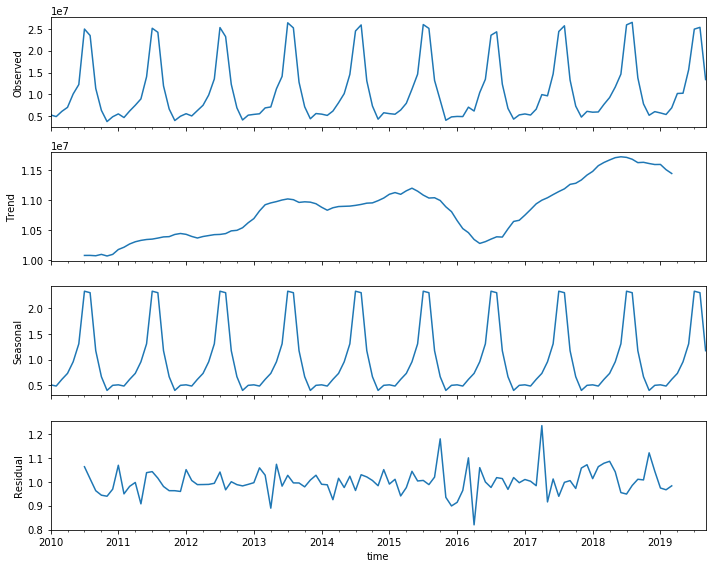

In [179]:
result = seasonal_decompose(france_after_2010, model='multiplicative', freq=12)
plt.figure(figsize=(500,500))
result.plot()
plt.show()

## SARIMA

parameter grid search best (2, 0, 2)

In [181]:
# parameter to try
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(france.value, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=52023404791490.117
ARIMA(0, 0, 1) MSE=20721580631449.398
ARIMA(0, 1, 0) MSE=29103026594173.715
ARIMA(0, 1, 1) MSE=21989310744203.559
ARIMA(0, 1, 2) MSE=20208794494813.074
ARIMA(0, 2, 0) MSE=34988640719103.543
ARIMA(0, 2, 1) MSE=28760636597410.297
ARIMA(1, 0, 0) MSE=26626993048957.973
ARIMA(1, 0, 1) MSE=18206860606897.660
ARIMA(1, 0, 2) MSE=18536510161077.309
ARIMA(1, 1, 0) MSE=25830476501022.148
ARIMA(1, 2, 0) MSE=35322619133222.281
ARIMA(2, 0, 0) MSE=19860958385229.402
ARIMA(2, 0, 1) MSE=18850635407788.816
ARIMA(2, 0, 2) MSE=17884552755570.789
ARIMA(2, 1, 0) MSE=22805747344412.016
ARIMA(2, 1, 1) MSE=19761157954399.559
ARIMA(2, 1, 2) MSE=18779711043663.371
ARIMA(2, 2, 0) MSE=29241234221360.781
Best ARIMA(2, 0, 2) MSE=17884552755570.789


walk-forward validation(takes time!):
Test RMSE: 1174755.296


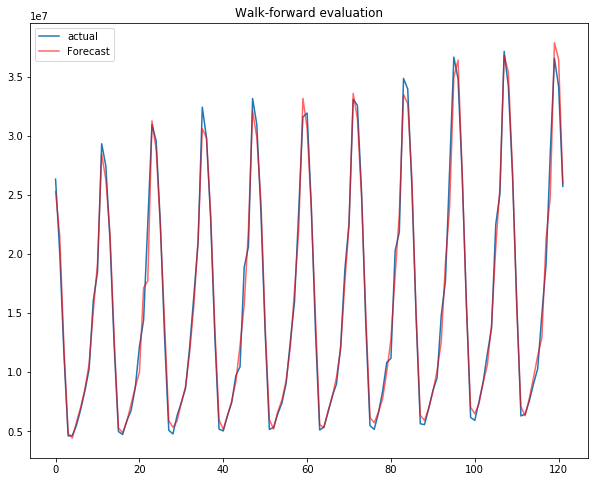

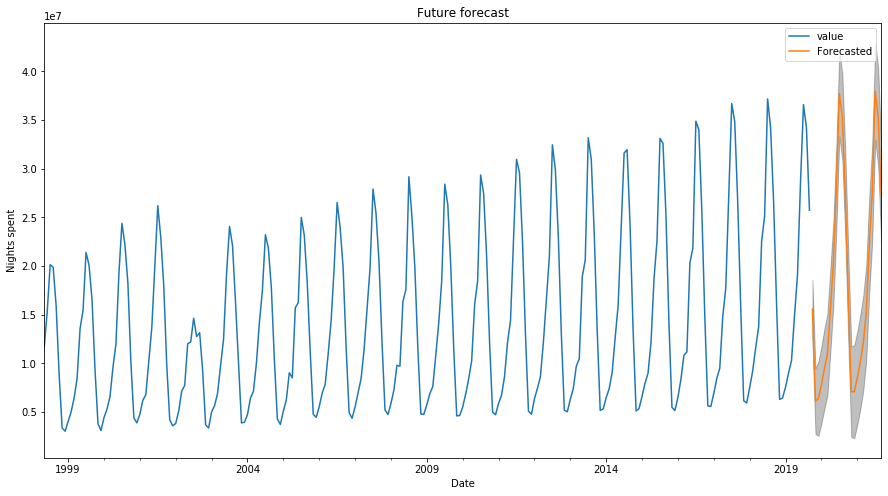

In [354]:
my_SARIMA(france, (2,1,2), 100)

## Italy

In [14]:
# get the data
italy = get_country_time_series('Italy')

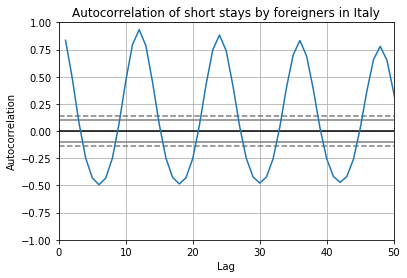

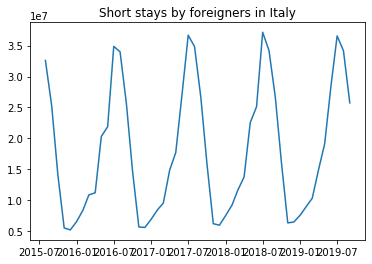

In [15]:
ax = autocorrelation_plot(italy)
ax.set_xlim([0,50])
plt.title("Autocorrelation of short stays by foreigners in Italy")
plt.show()
plt.title("Short stays by foreigners in Italy")
plt.plot(italy.tail(50))
plt.show()

<Figure size 36000x36000 with 0 Axes>

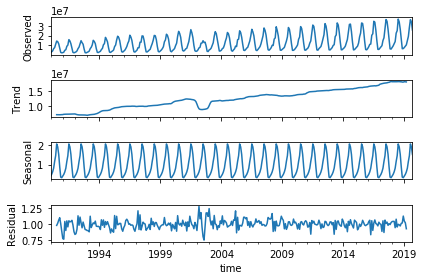

In [16]:
result = seasonal_decompose(italy, model='multiplicative', freq=12)
plt.figure(figsize=(500,500))
result.plot()
plt.show()

There is an obvious drop in the general trend of data between 2002 and 2001

## SARIMA

In [352]:
# parameter to try
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)
evaluate_models(italy.value, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=118983398479195.719
ARIMA(0, 0, 1) MSE=45558096677763.758
ARIMA(0, 1, 0) MSE=36300114394322.016
ARIMA(0, 1, 1) MSE=26941511365526.238
ARIMA(0, 1, 2) MSE=22054616465073.988
ARIMA(0, 2, 0) MSE=32238280128449.680
ARIMA(0, 2, 1) MSE=32537497420346.227
ARIMA(0, 2, 2) MSE=32271255433717.258
ARIMA(1, 0, 0) MSE=33591126548543.082
ARIMA(1, 0, 1) MSE=23728691908293.809
ARIMA(1, 0, 2) MSE=18497855011348.934
ARIMA(1, 1, 0) MSE=25248496138357.277
ARIMA(1, 1, 2) MSE=30368937706543.164
ARIMA(1, 2, 0) MSE=32666810877286.848
ARIMA(2, 0, 0) MSE=17059520607274.357
ARIMA(2, 0, 2) MSE=20781281776113.238
ARIMA(2, 1, 0) MSE=24426451613920.602
ARIMA(2, 2, 0) MSE=32799462981470.688
Best ARIMA(2, 0, 0) MSE=17059520607274.357


walk-forward validation(takes time!):
Test RMSE: 1158104.897


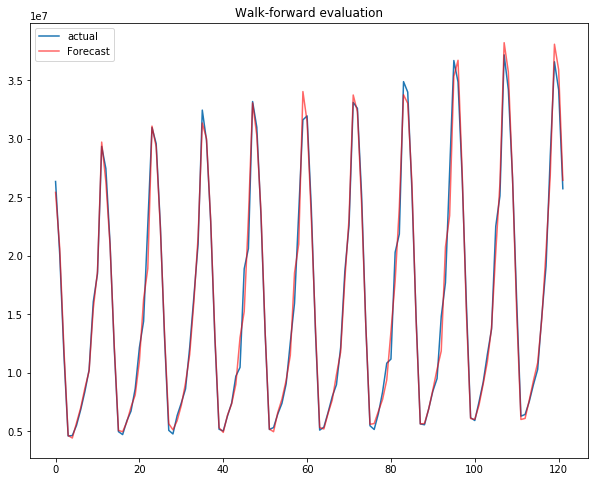

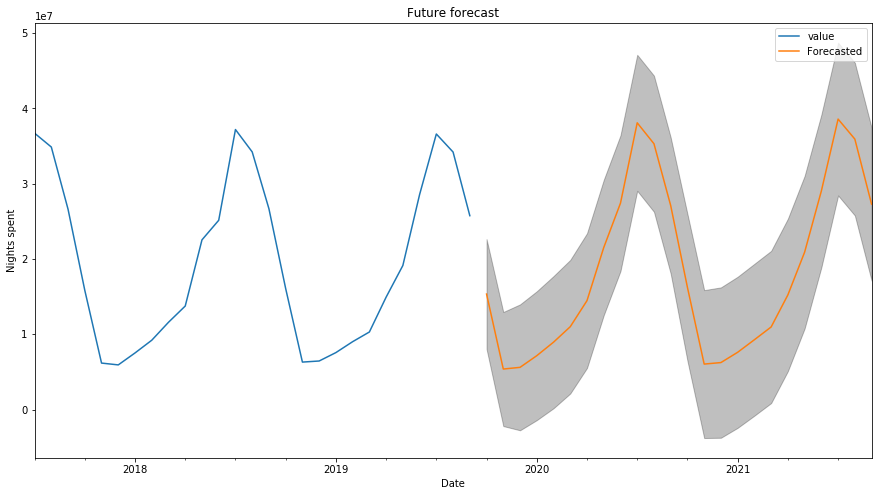

In [25]:
my_SARIMA(italy, (2, 0, 0), 330)